In [1]:
import tensorflow as tf
import os
import numpy as np
from osgeo import gdal, osr
import cv2
import matplotlib.pyplot as plt

In [2]:
def input_pipeline(filename, batch_size, is_shuffle=True, is_train=True, is_repeat=True):
    feature_description = {
        'image_raw': tf.io.FixedLenFeature([400*400*4], dtype=tf.int64),
        'label': tf.io.FixedLenFeature([400*400*1], dtype=tf.int64),
    }

    def _parse_function(example_proto):
        feature_dict = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.reshape(feature_dict['image_raw'], [400, 400, 4])
        image = tf.cast(image, tf.float32)

        image = image/10000

        label = tf.reshape(feature_dict['label'], [400, 400, 1])
        label = tf.cast(label, tf.float32)

        image_label = tf.concat([image, label], axis=-1)
        if is_train:
            image_label = tf.image.rot90(image_label, tf.random.uniform([], 0, 5, dtype=tf.int32))
            image_label = tf.image.random_flip_left_right(image_label)
            image_label = tf.image.random_flip_up_down(image_label)

        image = image_label[:, :, :4]
        label = image_label[:, :, -1]

        label = tf.cast(label, tf.int32)

        return image, label

    dataset = tf.data.TFRecordDataset(filename)
    if is_repeat:
        dataset = dataset.repeat()
    dataset = dataset.map(_parse_function)
    if is_shuffle:
        dataset = dataset.shuffle(buffer_size=1000)
    batch = dataset.batch(batch_size=batch_size)
    return batch

In [3]:
# downsampling step in the UNet
def downsample(filters, size):
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                      activation=tf.nn.relu,
                                      use_bias=True))
    result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                      activation=tf.nn.relu,
                                      use_bias=True))
    result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      activation=tf.nn.relu,
                                      use_bias=True))
    result.add(tf.keras.layers.BatchNormalization())

    return result


# upsampling step in the UNet
def upsample(filters, size):
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',
                                        activation=tf.nn.relu,
                                        use_bias=True))
    result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                      activation=tf.nn.relu,
                                      use_bias=True))
    result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.Conv2D(filters, size, strides=1, padding='same',
                                      activation=tf.nn.relu,
                                      use_bias=True))
    result.add(tf.keras.layers.BatchNormalization())

    return result


# U-Net model with two heads, one for cloud masking, another for cloud brightness
def unet_bn():
    down_stack = [
        downsample(16, 3),
        downsample(32, 3),
        downsample(64, 3),
    ]

    up_stack = [
        upsample(32, 3),
        upsample(16, 3),
    ]

    # cloud mask head
    last = tf.keras.Sequential()
    last.add(tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same',
                                            activation=tf.nn.relu))  # (bs, 128, 128, 16)
    last.add(tf.keras.layers.BatchNormalization())

    last.add(tf.keras.layers.Conv2D(16, 3, strides=1, padding='same',
                                    activation=tf.nn.relu))
    last.add(tf.keras.layers.BatchNormalization())

    last.add(tf.keras.layers.Conv2D(2, 1, strides=1, padding='same',
                                    activation=tf.nn.softmax))


    # Downsampling through the model
    skips = []
    concat = tf.keras.layers.Concatenate()

    # height = 200
    # width = 200
    inputs = tf.keras.layers.Input(shape=[None, None, 4])
    x = inputs
    print(x.shape)

    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)
    print(x.shape)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [4]:
BATCH_SIZE = 20
u_optimizer = tf.keras.optimizers.Adam(1e-4)
u_model = unet_bn()

(None, None, None, 4)
(None, None, None, 2)


In [7]:
def train_step(t_images, t_labels):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    with tf.GradientTape() as u_tape:
        prob = u_model(t_images, training=True)
        loss = ce_loss(t_labels, prob)
    gradients_of_u_model = u_tape.gradient(loss, u_model.trainable_variables)
    u_optimizer.apply_gradients(zip(gradients_of_u_model, u_model.trainable_variables))
    return prob

def train(train_ds, epoch):
    train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    for (t_images, t_labels) in train_ds:

        logits = train_step(t_images, t_labels)
        train_accuracy.update_state(t_labels, logits)
        # print(train_accuracy.result())

    train_acc = train_accuracy.result()
    print('train accuracy over epoch %d: %.2f'% (epoch+1, train_acc*100))

    return

In [6]:
folder = ['/content/drive/MyDrive/ice_cloud/l8ps_ds_2', '/content/drive/MyDrive/ice_cloud/l8ps_ds_3',
          '/content/drive/MyDrive/ice_cloud/l8ps_ds_4', '/content/drive/MyDrive/ice_cloud/l8ps_ds_5', '/content/drive/MyDrive/ice_cloud/l8ps_ds_6']
filenames = [os.path.join(folder[0], f) for f in os.listdir(folder[0]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[1], f) for f in os.listdir(folder[1]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[2], f) for f in os.listdir(folder[2]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[3], f) for f in os.listdir(folder[3]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]+\
            [os.path.join(folder[4], f) for f in os.listdir(folder[4]) if f.endswith('.tfrecords') and not f.endswith('full.tfrecords')]

filenames

['/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230308_212634_27_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230325_103503_19_240c.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230329_033637_63_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230402_144322_97_2402.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230417_072528_39_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094613_93_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230418_094636_32_2426.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230420_143108_00_2413.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192205_75_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230429_192219_98_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230503_122053_44_2414.tfrecords',
 '/content/drive/MyDrive/ice_cloud/l8ps_ds_2/20230515_223754_57_240c.tfrecords',
 '/content/drive/MyDrive/ice

In [ ]:
def train_process():
    train_ds = input_pipeline(filenames, BATCH_SIZE, is_repeat=False)

    for i in range(100):
        train(train_ds, i)
        if (i + 1) % 1 == 0:
            u_model.save_weights('unet.weights.h5')

train_process()

# Test

In [9]:
u_model.load_weights('/content/drive/MyDrive/ice_cloud/github_code/unet.weights.h5')

In [10]:
def tif2array(input_file):
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=int)

    for b in range(dataset.RasterCount):
        band = dataset.GetRasterBand(b + 1)
        image[:, :, b] = band.ReadAsArray()

    return image

In [11]:
folder_path = '/content/drive/MyDrive/ice_cloud/test_ds/dataset'
imgs = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs.sort()

folder_path = '/content/drive/MyDrive/ice_cloud/test_ds2/dataset'
imgs2 = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('ref.tif')]
imgs2.sort()
imgs = imgs+imgs2
imgs

['/content/drive/MyDrive/ice_cloud/test_ds/dataset/2022-04-15_strip_5573346_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-08-31_strip_6747657_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-09_strip_6763305_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-14_strip_6774056_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-20_strip_6786319_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-21_strip_6788017_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-24_strip_6793653_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-09-27_strip_6800261_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-06_strip_6818915_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-08_strip_6823217_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/2023-10-13_strip_6833728_ref.tif',
 '/content/drive/MyDrive/ice_cloud/test_ds/dataset/202

In [12]:
def clip_center(img, clip_height, clip_width):
    """
    Clips the center part of the image.

    Parameters:
    - img: 2D or 3D NumPy array representing the image.
    - clip_height: Height of the central clip.
    - clip_width: Width of the central clip.

    Returns:
    - Clipped center part of the image as a NumPy array.
    """
    # Get image dimensions
    img_height, img_width = img.shape[:2]

    # Calculate the center coordinates
    center_y, center_x = img_height // 2, img_width // 2

    # Define the starting and ending points for the clipping
    start_y = max(center_y - clip_height // 2, 0)
    end_y = min(center_y + clip_height // 2, img_height)
    start_x = max(center_x - clip_width // 2, 0)
    end_x = min(center_x + clip_width // 2, img_width)

    # Return the clipped center part
    return img[start_y:end_y, start_x:end_x]

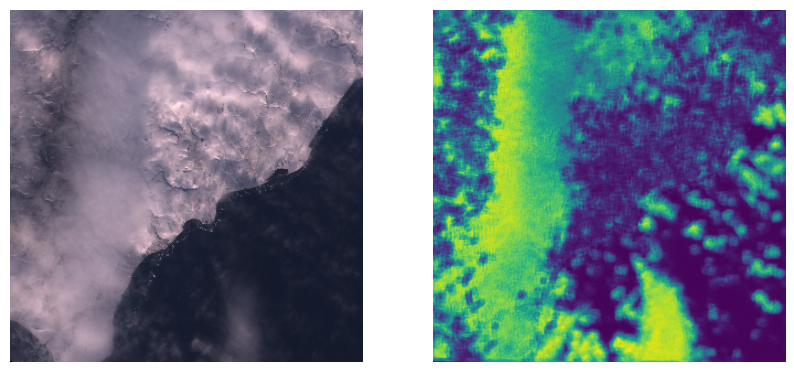

In [17]:
for img_path in imgs[2:3]:
    img = tif2array(img_path)
    img = clip_center(img, 3200, 3200)

    img = img/10000

    img = tf.reshape(img, [1, 3200, 3200, 4])
    pred = u_model(img, training=False)

    plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(img[0, ::10, ::10, 2::-1], vmin=0, vmax=1)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(pred.numpy()[0, :, :, 1], vmin=0, vmax=1)

    # np.save(img_path[:-7]+'unet.npy', pred.numpy()[0, :, :, 1])